# Cleaning

In [1]:
import pandas as pd
from nltk.corpus import stopwords


def filterByNumWords(df: pd.DataFrame, numWords: int) -> pd.DataFrame:
    """
    Filter out comments that have fewer words than numWords

    :param df: dataframe
    :param numWords: int
    :return: dataframe with comments with fewer words than numWords filtered out
    """

    if "comment_text_words" not in df.columns:
        df = splitIntoWords(df)

    return df.loc[df["comment_text_words"].str.len() > numWords]


def filterNonEnglishChars(df: pd.DataFrame) -> pd.DataFrame:
    """
        Filter out non-english characters

        :param df: dataframe
        :return: dataframe with non-english characters filtered out
    """

    # df["comment_text"] = df['comment_text'].str \
    #     .encode('ascii', 'ignore').str.decode('ascii')
    df["comment_text"].replace(r"[^A-Za-z\s]+", "", regex=True,
                               inplace=True)

    return df


def removeStopWords(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove stop words

    :param df: dataframe
    :return: dataframe with stop words removed
    """

    wordsToRemove = stopwords.words('english')
    pattern = r"\b({})\b".format('|'.join(wordsToRemove))
    df["comment_text"] = df["comment_text"].str.replace(
        pattern, "", regex=True)

    return df


def toLowerCase(df: pd.DataFrame) -> pd.DataFrame:
    """
    Forces all characters to be lowercase

    :param df: dataframe
    :return: dataframe with all characters forced to be lowercase
    """

    df["comment_text"] = df["comment_text"].str.lower()

    return df


def splitIntoWords(df: pd.DataFrame) -> pd.DataFrame:
    """
    Split comments into words and forces them to be lowercase

    :param df: dataframe
    :return: dataframe with comments split into words
    """

    df["comment_text_words"] = df["comment_text"].str.split("\\s+")

    return df


def isEnglish(s: str) -> bool:
    """
    Check if a string contains all english characters

    :param s: string to check
    :return: whether string contains only english characters
    """

    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True


def trimWhitespace(df: pd.DataFrame) -> pd.DataFrame:
    df["comment_text"] = df["comment_text"].str.strip()

    return df

In [4]:
import nltk
nltk.download('stopwords')

def cleanData():
    df = pd.read_csv("train.csv")
    df = toLowerCase(df)
    df = filterNonEnglishChars(df)
    df = removeStopWords(df)
    df = trimWhitespace(df)
    df = splitIntoWords(df)
    df = filterByNumWords(df, 3)

    df.to_csv("train_cleaned.csv", index=False)

cleanData()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Exploring

In [22]:
data = pd.read_csv("train.csv")

data.info()
print()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB



,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [23]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter


def graphBasedOnNumWords(df: pd.DataFrame) -> None:
    """
    Graphs the number of words in each comment.
    :param df: The Pandas DataFrame.
    :return: None.
    """
    df["num_words"] = df["comment_text"].apply(lambda x: len(x.split()))
    df["num_words"].hist(bins=30, range=(0, 300),
                         weights=np.ones(len(df)) / len(df))
    plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
    plt.title("Number of Words in Each Comment")
    plt.xlabel("Number of Words")
    plt.ylabel("Number of Comments")
    plt.show()
    plt.close()
    print(df["num_words"].describe())


def getFrequencyOfWords(df: pd.DataFrame) -> None:
    """
    Gets the frequency of words in all comment.
    :param df: The Pandas DataFrame.
    :return: None.
    """
    print(pd.Series(" ".join(df["comment_text"]).split()).value_counts()[:20])


def getFrequencyOfToxicWords(df: pd.DataFrame) -> None:
    """
    Gets the frequency of words in all comment.
    :param df: The Pandas DataFrame.
    :return: None.
    """

    # Toxicity types to filter by
    toxicValues = ["toxic", "severe_toxic", "obscene", "threat", "insult",
                   "identity_hate"]
    # toxicValues = ["identity_hate"]

    # Number of toxicity types
    numToxicTypes = 1
    # numToxicTypes = 6

    filteredDf = df.loc[df[toxicValues].sum(axis=1) >= numToxicTypes]

    print(pd.Series(" ".join(filteredDf["comment_text"]).split())
          .value_counts()[:20])
    
def getFrequencyOfEachToxicTag(df: pd.DataFrame) -> None:
    """
    For each of the 6 toxicity tags, it finds the number of rows
    in the pandas dataframe corresponding to that tag. Prints 
    that information and produces a corresponding plot
    :param df: The Pandas DataFrame.
    :return: None.
    """
    cols = data.columns
    tags = cols[2:-1]

    tagFrequencies = []

    for tag in tags:
        cnt = (data[tag] == 1).sum()
        percentage = round((cnt / data.shape[0]) * 100, 4)
        tagFrequencies.append((tag, percentage))
        print("Percentage with tag {col_name} is {x}%".format(col_name = tag, x = percentage))
    
    tagFrequencies = sorted(tagFrequencies, key=lambda x: x[1], reverse=True)

    x_axis_tags = [pr[0] for pr in tagFrequencies]
    y_axis_percentages = [pr[1] for pr in tagFrequencies]

    # create a bar graph
    plt.bar(x_axis_tags, y_axis_percentages, color ='maroon', width = 0.4)

    # set the title and labels
    plt.title('Toxicity Tag Frequency Percentages')
    plt.xlabel('Toxicity Tag')
    plt.ylabel('Percentage')

    # display the graph
    plt.show()

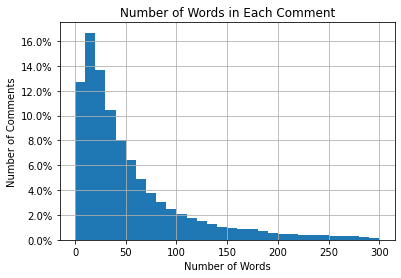

count    159571.000000
mean         67.273527
std          99.230702
min           1.000000
25%          17.000000
50%          36.000000
75%          75.000000
max        1411.000000
Name: num_words, dtype: float64


In [24]:
graphBasedOnNumWords(data)

In [25]:
getFrequencyOfWords(data)

the     445987
to      288817
of      219334
and     207381
a       201817
I       183930
is      164639
you     157272
that    140545
in      130262
for      96010
it       92651
on       84453
not      83944
"        81755
be       80928
this     71429
have     69414
as       68345
are      66277
dtype: int64


Percentage with tag toxic is 9.5844%
Percentage with tag severe_toxic is 0.9996%
Percentage with tag obscene is 5.2948%
Percentage with tag threat is 0.2996%
Percentage with tag insult is 4.9364%
Percentage with tag identity_hate is 0.8805%


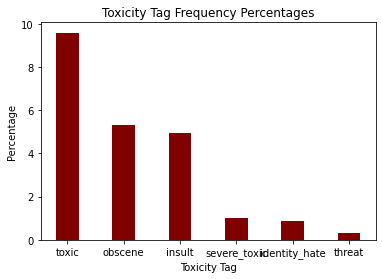

In [26]:
getFrequencyOfEachToxicTag(data)

In [27]:
data = pd.read_csv("train_cleaned.csv")

data.info()
print()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149348 entries, 0 to 149347
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   id                  149348 non-null  object
 1   comment_text        149348 non-null  object
 2   toxic               149348 non-null  int64 
 3   severe_toxic        149348 non-null  int64 
 4   obscene             149348 non-null  int64 
 5   threat              149348 non-null  int64 
 6   insult              149348 non-null  int64 
 7   identity_hate       149348 non-null  int64 
 8   comment_text_words  149348 non-null  object
dtypes: int64(6), object(3)
memory usage: 10.3+ MB



,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text_words
0,0000997932d777bf,explanation\n edits made username hardcore ...,0,0,0,0,0,0,"['explanation', 'edits', 'made', 'username', '..."
1,000103f0d9cfb60f,daww matches background colour im seemingly ...,0,0,0,0,0,0,"['daww', 'matches', 'background', 'colour', 'i..."
2,000113f07ec002fd,hey man im really trying edit war guy c...,0,0,0,0,0,0,"['hey', 'man', 'im', 'really', 'trying', 'edit..."
3,0001b41b1c6bb37e,cant make real suggestions improvement won...,0,0,0,0,0,0,"['cant', 'make', 'real', 'suggestions', 'impro..."
4,0001d958c54c6e35,sir hero chance remember page thats,0,0,0,0,0,0,"['sir', 'hero', 'chance', 'remember', 'page', ..."


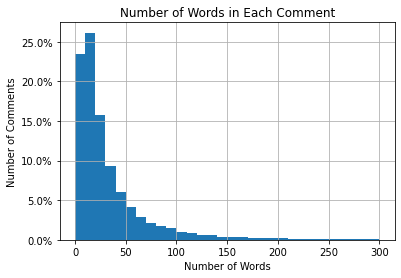

count    149348.000000
mean         36.412239
std          53.904201
min           4.000000
25%          10.000000
50%          20.000000
75%          40.000000
max        1250.000000
Name: num_words, dtype: float64


In [28]:
graphBasedOnNumWords(data)

In [29]:
getFrequencyOfWords(data)

article      55303
page         45511
wikipedia    35516
talk         31061
please       29482
would        29176
one          27975
like         27624
dont         25986
see          21362
also         20482
think        19943
im           19401
know         18908
people       17667
edit         17514
articles     17495
use          16299
may          15507
time         15364
dtype: int64


Percentage with tag toxic is 9.3299%
Percentage with tag severe_toxic is 0.9655%
Percentage with tag obscene is 5.1069%
Percentage with tag threat is 0.302%
Percentage with tag insult is 4.7821%
Percentage with tag identity_hate is 0.8684%
Percentage with tag comment_text_words is 0.0%


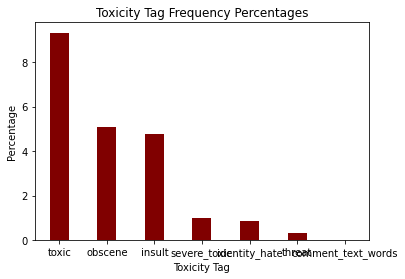

In [30]:
getFrequencyOfEachToxicTag(data)